In [41]:
import itertools
import _pickle as cPickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_curve, precision_score, recall_score, auc, precision_recall_curve
from sklearn.model_selection import  train_test_split
import xgboost as xgb
import seaborn as sns

seed = 9999
%matplotlib inline

##Load email dataset

In [11]:
emails = pd.read_csv('C:/Users/siyue/OneDrive/Desktop/Machine Learning/Data/email/email_table.csv',
                    index_col = 'email_id')
emails.sample(10) # Take a glance at the data

,email_text,email_version,hour,weekday,user_country,user_past_purchases
email_id,,,,,,
616322,long_email,personalized,7,Thursday,US,7
628971,short_email,personalized,2,Wednesday,US,0
608606,long_email,generic,7,Thursday,US,2
144124,short_email,generic,10,Monday,UK,8
574215,short_email,personalized,5,Tuesday,FR,8
180218,short_email,generic,9,Friday,UK,0
105170,short_email,generic,5,Friday,ES,9
916316,long_email,personalized,11,Friday,UK,9
56667,long_email,generic,6,Wednesday,ES,0


In [12]:
# Process with "email_text"
# Change "long text" (has 4 paragraphs) and "short text" (has 2 paragraphs) to 4 and 2.
emails['paragraphs'] = np.where(emails.email_text == 'short_email', 2, 4)
del emails['email_text']

In [13]:
# Process with "email_version"
# Change "personalized" and "generic" to 1 and 0.
emails['is_personal'] = (emails.email_version == 'personalized').astype(np.int)

In [14]:
#Process with "weekday"
weekday2index = {"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6,"Sunday":7}
emails["weekday"] = emails.weekday.map(weekday2index)

# rename long column names to shorter names, make it easier to read
emails.rename(columns={'user_past_purchases':'purchases','user_country':'country'},inplace=True)

In [16]:
# Assemble emails' response together
emails["response"] = "received"

open_users = pd.read_csv('C:/Users/siyue/OneDrive/Desktop/Machine Learning/Data/email/email_opened_table.csv').email_id
emails.loc[open_users,"response"] = "opened"

click_users = pd.read_csv('C:/Users/siyue/OneDrive/Desktop/Machine Learning/Data/email/link_clicked_table.csv').email_id
emails.loc[click_users,"response"] = 'clicked'

In [17]:
emails.head()# check some data to get a feeling

,email_version,hour,weekday,country,purchases,paragraphs,is_personal,response
email_id,,,,,,,,
85120,personalized,2,7,US,5,2,1,received
966622,personalized,12,7,UK,2,4,1,clicked
777221,personalized,11,3,US,2,4,1,received
493711,generic,6,1,UK,1,2,0,received
106887,generic,14,1,US,6,4,0,received


In [18]:
emails.to_csv("clean_emails.csv",index_label="email_id")

##Answer Question 1

What percentage of users opened the email?
what percentage clicked on the link within the email?

In [19]:
rslt_dist = emails.response.value_counts(normalize=True)
rslt_dist

received    0.89605
opened      0.08276
clicked     0.02119
Name: response, dtype: float64

In [21]:
print ("{:.2f}% of users opened the email".format((1 - rslt_dist.received) * 100))
print ("{:.2f}% of users clicked the link".format(rslt_dist.clicked * 100))

10.39% of users opened the email
2.12% of users clicked the link


##Explore the Data

In [23]:
def count_result_ratio(df):
    counts = df.response.value_counts(normalize=True)
    counts['total'] = df.shape[0]
    return counts

def grp_count_plotbar(key):
    grpresult = emails.groupby(key).apply(count_result_ratio)
    # grpresult.loc[:,["received","opened",'clicked']].plot(kind='bar')
    grpresult.loc[:,['clicked']].plot(kind='bar',title='click ratio vs. {}'.format(key))
    plt.ylabel('click ratio')
    return grpresult

###Chi-square test and F-test

In [30]:
resp_lb_encoder = LabelEncoder()
cnty_lb_encoder = LabelEncoder()

X = emails.copy()
y = resp_lb_encoder.fit_transform(X.response)
del X["response"]

feat_names = ["hour","weekday","country","purchases","paragraphs","is_personal" ]
X = X.loc[:,feat_names]
X["country"] = cnty_lb_encoder.fit_transform(X.country)

chi2scores,_ = chi2(X,y)
fscores,_ = f_classif(X,y)

feat_scores = pd.DataFrame({"chi2scores":chi2scores,"fscores":fscores},index=feat_names)

In [31]:
feat_scores.sort_values(by='chi2scores',ascending=False)

,chi2scores,fscores
purchases,3448.795660,663.388596
country,378.554465,435.696911
is_personal,316.752872,317.427444
weekday,210.006087,105.002643
hour,147.815921,33.992047
paragraphs,53.952439,81.209295


In [32]:
feat_scores.sort_values(by="fscores",ascending=False)

,chi2scores,fscores
purchases,3448.795660,663.388596
country,378.554465,435.696911
is_personal,316.752872,317.427444
weekday,210.006087,105.002643
paragraphs,53.952439,81.209295
hour,147.815921,33.992047


From the test result, we can know that:

1. Important features: previous purchase counts, user's country, email's version (personal or general)
2. Not so important features maybe include: weekday, email's text (short or long), hour to send the email

###Previous purchase vs. response

In [33]:
rslt_grpby_purchase = emails.groupby("purchases").apply(count_result_ratio).unstack()
rslt_grpby_purchase.fillna(value=0,inplace=True)

Text(0,0.5,'ratio')

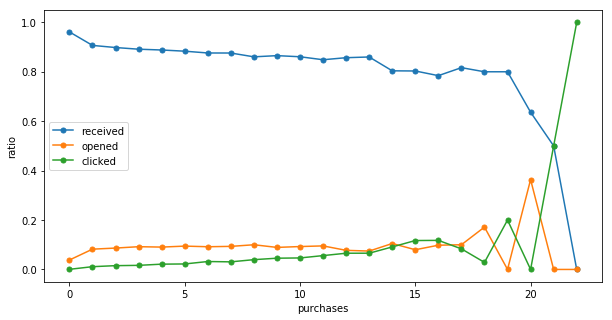

In [34]:
plt.rc('figure', figsize=(10, 5))
rslt_grpby_purchase.loc[:,["received","opened",'clicked']].plot(marker='o',markersize=5)
plt.ylabel("ratio")

From plot above, we can know, the more items a certain user purchased previously, the more likely that user will open the email or click the link.

###User's country vs. response

response,received,opened,clicked,total
country,,,,
ES,0.960570,0.031103,0.008327,9967.0
FR,0.958779,0.033217,0.008004,9995.0
UK,0.879282,0.096043,0.024675,19939.0
US,0.880481,0.095160,0.024360,60099.0


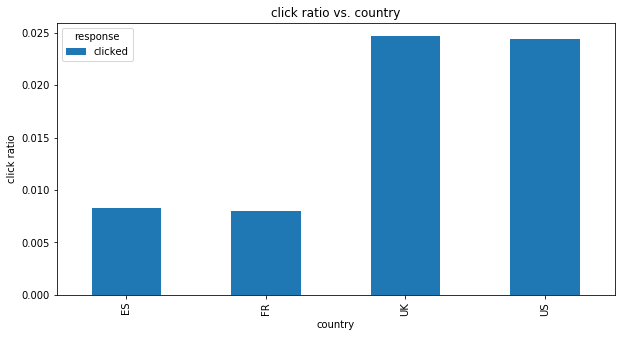

In [35]:
grp_count_plotbar('country')

From above plots, we see that, 'open percentage' and 'click percentage' is much higher (nearly 3 times) in UK and US than in France and Spain.

This may be the translation issue. I guess the emails are written in English, which is unreadable to some non-English-speaking users, which cause the low 'click ratio' in non-English-speaking countries.

###Email version vs. response

response,received,opened,clicked,total
is_personal,,,,
0,0.920034,0.064829,0.015137,50209.0
1,0.871864,0.100842,0.027294,49791.0


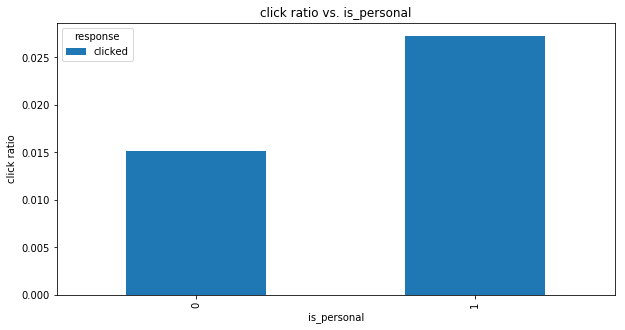

In [38]:
grp_count_plotbar('is_personal')

'personalized email' has higher 'click ratio' than 'general email'. this is very easy to understand. Having my name in the recipient, at least I am some kind of 'important' to the company, other than some ordinary people which the company don't bother to remember his name.

###Weekday vs. Response

response,received,opened,clicked,total
weekday,,,,
1,0.883590,0.093504,0.022906,14363.0
2,0.879092,0.096019,0.024889,14143.0
3,0.879296,0.093084,0.027620,14084.0
4,0.881348,0.094207,0.024445,14277.0
5,0.925019,0.060944,0.014037,14177.0
6,0.912005,0.070149,0.017846,14569.0
7,0.911448,0.071801,0.016751,14387.0


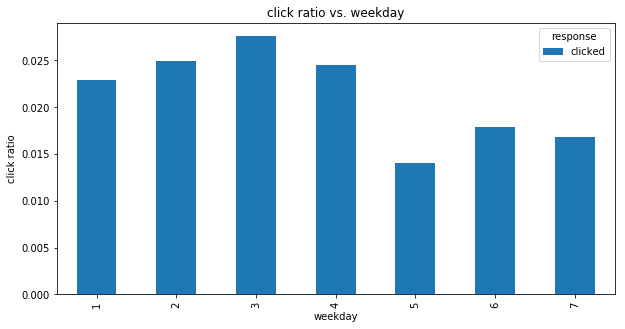

In [39]:
grp_count_plotbar('weekday')

Friday, Saturday, Sunday have obviously lower 'click ratio' than Monday to Thursday. People normally don't process emails during weekends.

###Sending hour vs. Response

Text(0.5,1,'Count Plot of Email Sent Hour')

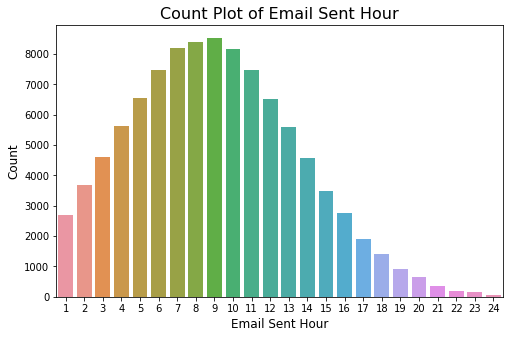

In [53]:
# Count of each hour
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(x='hour', data=emails)
ax.set_xlabel('Email Sent Hour', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Count Plot of Email Sent Hour', fontsize=16)

response,received,opened,clicked,total
hour,,,,
1,0.910840,0.071032,0.018128,2703.0
2,0.911589,0.072089,0.016322,3676.0
3,0.915184,0.065293,0.019523,4610.0
4,0.911419,0.072394,0.016186,5622.0
5,0.917417,0.064570,0.018013,6551.0
6,0.909176,0.073677,0.017147,7465.0
7,0.909434,0.072282,0.018284,8204.0
8,0.911407,0.069659,0.018933,8398.0
9,0.873725,0.100481,0.025794,8529.0


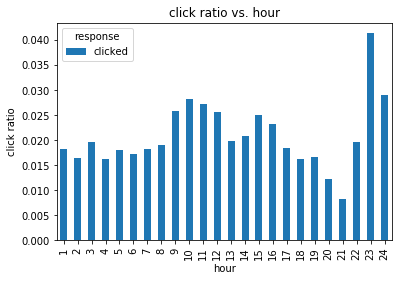

In [43]:
grp_count_plotbar('hour')

Although from above plot, it seems 'sending hour' has some impact on 'clicked ratio'. however, that may be caused by much fewer examples in late hours. also according to statistical test's result, I don't think 'sending hour' is an important feature, and won't include it in my model.

##Question 4

Interesting pattern on how the email campaign performed for diﬀerent segments of users?

From above explorary analysis, I can find some interesting patterns listed below:

1. The more item a certain user purchased in the past, the more likely that user will click the link
2. Users from English-speaking coutries are more likely to click the link, which may be caused by some translation issue.
3. Personalized email is more likely to be opened and clicked
4. Emails sent at weekends is less likely to be opened and clicked
5. Sending hour and #Paragraphs are not very important features to affect click rate

##Build Predictive Model

In this section, I will build a model to predict whether a user will open the email and click the link inside it.

###Prepare data

In [60]:
del X
X = emails.copy()
X.sample(5) # Take a glance at current data

,email_version,hour,weekday,country,purchases,paragraphs,is_personal,response
email_id,,,,,,,,
280897,generic,8,6,UK,7,2,0,received
153471,personalized,12,2,US,2,2,1,received
277306,generic,7,4,US,3,4,0,received
908175,generic,16,4,US,14,4,0,received
59733,generic,8,2,UK,0,4,0,received


In [61]:
# select original features
# 'paragraphs' isn't an important feature, but I will include it, and see how RF say about it
X = X.loc[:,["country","purchases","paragraphs","is_personal"] ]

# create new feature
X['is_weekend'] = (emails.weekday>=5).astype(int)

# One-Hot-Encode 'country' feature
X = pd.get_dummies(X,columns=["country"],drop_first=True)

# prepare the target
y = (emails.response == 'clicked').astype(int)

In [62]:
X.sample(5)

,purchases,paragraphs,is_personal,is_weekend,country_FR,country_UK,country_US
email_id,,,,,,,
410128,4,4,1,1,0,0,1
208671,2,4,1,1,0,1,0
681557,4,4,1,1,0,0,1
212341,10,2,1,0,0,1,0
512608,12,2,0,0,1,0,0


In [63]:
# split for training and testing
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33333,random_state = seed)

In [64]:
print ('Train set shape: {}, positive ratio={:.3f}'.format(Xtrain.shape,ytrain.mean()))
print ('Test set shape: {}, positive ratio={:.3f}'.format(Xtest.shape,ytest.mean()))

Train set shape: (66667, 7), positive ratio=0.021
Test set shape: (33333, 7), positive ratio=0.022


###Train the model

Due to time limitation, I will just train one GBM model.

If given sufficient time, I will apply fowllowing strategies to improve the model:

Build multiple models, and ensemble them (average or stacking) to improve the prediction performance.
Try more hyper-parameters to find better ones.

In [65]:
train_matrix = xgb.DMatrix(Xtrain,ytrain)
test_matrix = xgb.DMatrix(Xtest)

In [66]:
params = {}
params['objective'] = 'binary:logistic'  # output probabilities
params['eval_metric'] = 'auc'
params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = seed)

[15:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[15:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[15:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	train-auc:0.618659+0.0514815	test-auc:0.612511+0.0485177
[15:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[15:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:15:02] src/tree/updater_prune.cc:74: tree prun

In [68]:
n_best_trees = cv_results.shape[0]
print ("best number of trees: {}".format(n_best_trees))

best number of trees: 69


In [69]:
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)

[15:18:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.702188
[15:18:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-auc:0.704781
[15:18:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-auc:0.71018
[15:18:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-auc:0.714805
[15:18:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-auc:0.715547
[15:18:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-auc:0.726005
[15:18:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-auc:0.725821
[15:18:57] src/tree/updater_prune.cc:74: tree pruning end

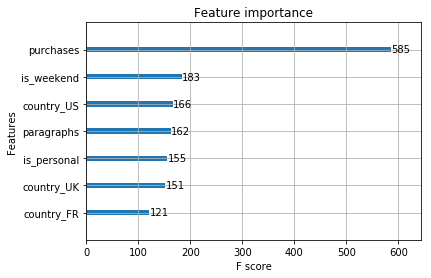

In [70]:
# plot feature importances
xgb.plot_importance(gbt)

Above feature importance match the result from explorary analysis.

###Plot ROC curve and choose better probability threshold

Since the data is highly imbalanced (positive examples is only 2% of the total examples), if using default probability threshold (0.5), the model just classify every example as negative, so we need to plot the ROC curve and choose a better probability threshold.

But ROC cannot be plot on either training set or test set. so I split the original train set into 'training' and 'validation' sets, re-train on 'training set' and plot ROC on 'validation set'.

In [71]:
print ("n_best_trees={},xgboost parameters: ".format(n_best_trees))
params

n_best_trees=69,xgboost parameters: 


{'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'num_rounds': 300,
 'early_stopping_rounds': 30,
 'max_depth': 6,
 'eta': 0.1,
 'subsample': 0.8,
 'colsample_bytree': 0.8}

In [72]:
# define a function, avoid pollute the current namespace
def validation_roc():
    Xtrain_only,Xvalid,ytrain_only,yvalid = train_test_split(Xtrain,ytrain,test_size=0.2,random_state=seed)
    
    train_only_matrix = xgb.DMatrix(Xtrain_only,ytrain_only)
    valid_matrix = xgb.DMatrix(Xvalid)
    
    # retrain on training set
    gbt_train_only = xgb.train(params, train_only_matrix, n_best_trees)
    
    # predict on validation set
    yvalid_probas = gbt_train_only.predict(valid_matrix, ntree_limit=n_best_trees)
    
    d = {}
    d['FPR'],d['TPR'],d['Threshold'] = roc_curve(yvalid,yvalid_probas)
    return pd.DataFrame(d)

In [73]:
roc_results = validation_roc()

[15:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[15:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[15:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[15:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[15:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[15:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_dept

Text(0,0.5,'TPR')

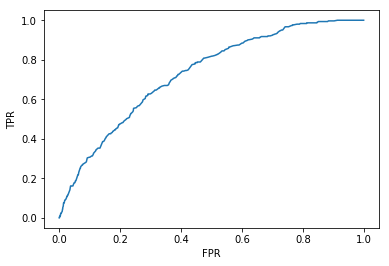

In [74]:
_ = plt.figure()
plt.plot(roc_results.FPR,roc_results.TPR)
plt.xlabel("FPR")
plt.ylabel('TPR')

According to above ROC curve and make a compromise between Precision and Recall, I decide to choose a threshold which makes TPR at about 0.6, then FPR will be about 0.3, which I think is acceptable.

In [75]:
roc_results.loc[(roc_results.TPR > 0.6) & (roc_results.TPR < 0.65),:]

,FPR,TPR,Threshold
188,0.282327,0.603960,0.028763
189,0.283094,0.610561,0.028586
190,0.283785,0.613861,0.028554
191,0.284859,0.617162,0.028472
192,0.285089,0.617162,0.028386
193,0.287008,0.617162,0.027836
194,0.287929,0.617162,0.027603
195,0.288159,0.617162,0.027312
196,0.290538,0.620462,0.027229
197,0.290845,0.623762,0.027137


In [76]:
# choose a threshold based on ROC
# FPR=0.292380, TPR=0.630363, Threshold=0.029118
pos_prob_threshold = 0.029118

def adjust_predict(matrix):
    y_probas = gbt.predict(matrix, ntree_limit=n_best_trees)
    return (y_probas > pos_prob_threshold).astype(int)

In [78]:
ytrain_pred = adjust_predict(train_matrix)
print (classification_report(ytrain,ytrain_pred))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85     65265
           1       0.05      0.61      0.09      1402

   micro avg       0.74      0.74      0.74     66667
   macro avg       0.52      0.68      0.47     66667
weighted avg       0.97      0.74      0.83     66667



In [79]:
ytest_pred = adjust_predict(test_matrix)
print (classification_report(ytest,ytest_pred))

              precision    recall  f1-score   support

           0       0.99      0.74      0.84     32616
           1       0.04      0.56      0.08       717

   micro avg       0.73      0.73      0.73     33333
   macro avg       0.52      0.65      0.46     33333
weighted avg       0.97      0.73      0.83     33333



In [80]:
print ("test precision: {:.2f}%".format(precision_score(ytest,ytest_pred) * 100))
print ("test recall: {:.2f}%".format(recall_score(ytest,ytest_pred) * 100))

test precision: 4.44%
test recall: 55.51%


In [81]:
gbt.save_model('gbt.model')

##Question 2 and question 3's first part

1. The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?
2. By how much do you think your model would improve click through rate ( deﬁned as # of users who click on the link / total users who received the email). How would you test that?

I have build a Gradient Boosting Tree model in previous section which predicts whether a user will click the link or not. Then the new email campaign strategy will be: only send email to users which my GBM model predicts positive.

In [82]:
n_emails_old_sent = ytest_pred.shape[0]
n_emails_new_sent = ytest_pred.sum()
saving_percentage = 100 - n_emails_new_sent * 100.0/n_emails_old_sent
pd.Series({'#emails sent in old way': n_emails_old_sent,
           '#emails sent in new way': n_emails_new_sent,
           'saving percentage (%)': saving_percentage})

#emails sent in old way    33333.000000
#emails sent in new way     8973.000000
saving percentage (%)         73.080731
dtype: float64

According to its predictive result on test set:

1. My model only need to send 30% of the old email amount, saving 70% amount.
2. My model will cover 60% of valued users which will click the link.
3. 4.35% of the receiver will open email and click the link. compare with old strategy, whose click rate is 2.12% , my new strategy can double the click rate.

##Question 3's second part

By how much do you think your model would improve click through rate ( deﬁned as # of users who click on the link / total users who received the email). How would you test that?

To test my conclusion, we need to perform a A/B test:

1. randomly assign users to two groups, Control group and Experiment group.
2. In Control group, still use the old email-campaign strategy, i.e., just send emails to all users in Control group.
3. In Experiment group, use my model to predict whether the user will click the link or not. and only send emails to those users whose predictive result is positive.
4. Then we preform a one-tail unpaired t-test to test whether Experiement group's population proportion is higher than Control group's population proportion.